In [1]:
import duckdb
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
# Connect to DuckDB (in-memory for this example)
con1 = duckdb.connect(database='S2_papers_cleaned.db')
con2 = duckdb.connect(database='S2_papers_cleaned_additional_papers.db')


In [10]:
# select only (corpusid,is_ai,is_physics,is_psych) columns from both databases
query = """
SELECT corpusid, is_ai, is_physics, is_psych
FROM papers_with_abstracts 
"""
df1 = con1.execute(query).fetchdf()
df2 = con2.execute(query).fetchdf()
# concatenate both dataframes
df = pd.concat([df1, df2], ignore_index=True)
print(df.head())

    corpusid  is_ai  is_physics  is_psych
0  214745815  False       False      True
1  119306079  False        True     False
2  234399577   True       False     False
3  123487525  False        True     False
4   18695655  False        True     False


In [ ]:
# Create a subset of just the flag columns
cols = ['is_physics', 'is_ai', 'is_psych']

# idxmax returns the column name where the value is max (1)
# We then map those column names to your cleaner labels
field_map = {'is_physics': 'Physics', 'is_ai': 'AI', 'is_psych': 'Psychology'}

df['field'] = df[cols].idxmax(axis=1).map(field_map)

# Note: If a row has all 0s, idxmax might pick the first column arbitrarily. 
# You'd need to mask those out afterward if 'Other' is important.
df.loc[df[cols].sum(axis=1) == 0, 'field'] = 'Other'

field
Physics       967729
Psychology    857032
AI            739852
Name: count, dtype: int64

In [15]:
# create a new database and store df[corpusid, field] in it
con3 = duckdb.connect(database='s2_papers_fields.db')
con3.execute("CREATE TABLE papers_fields AS SELECT corpusid, field FROM df")
con3.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
# list all tables in the database
query = """
SELECT * EXCLUDE (abstract,is_ai,is_physics,is_psych)
FROM papers_with_abstracts 
"""
df1 = con1.execute(query).fetchdf()
df2 = con2.execute(query).fetchdf()
df2.drop(columns=['externalids','usable','match_method'], inplace=True)
df = pd.concat([df1, df2], ignore_index=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [15]:
# df = df[df['primary_topic'].isin(df['primary_topic'].value_counts()[df['primary_topic'].value_counts()>100].index.tolist())]
# df.reset_index(drop=True, inplace=True)
df.head()

,corpusid,title,publication_date,citation_count,influential_citation_count,primary_topic
0,214745815,Using Expectancy Violations Theory to Understa...,2020-03-23,10,0,Psychology of Social Influence
1,119306079,Rapidity scaling of multiplicity and flow in w...,2009-11-25,11,0,High-Energy Particle Collisions Research
2,234399577,Mining High Utility Itemsets Based on Pattern ...,2020-12-25,9,0,Data Mining Algorithms and Applications
3,123487525,First Principles Study of Cerium Monochalcogen...,2014-07-21,0,0,Rare-earth and actinide compounds
4,18695655,From boundary to bulk in logarithmic CFT,2007-07-03,110,7,Black Holes and Theoretical Physics


### **Citation per Year**
Simply divided the citations of the paper by number of years since it was published

In [16]:
df['citation_count_per_year'] = df['citation_count'] / (2025 - pd.to_datetime(df['publication_date']).dt.year + 1)
df['influential_count_per_year'] = df['influential_citation_count'] / (2025 - pd.to_datetime(df['publication_date']).dt.year + 1)
df['publication_year'] = pd.to_datetime(df['publication_date']).dt.year

### Percentile of the Paper Ranked using the Citation per Year

In [ ]:
# Rank papers within their own topic from 0.0 to 1.0
df['percentile_rank_per_year_citation'] = df.groupby('primary_topic')['citation_count_per_year'].rank(pct=True)
df['percentile_rank_per_year_influential'] = df.groupby('primary_topic')['influential_count_per_year'].rank(pct=True)


### **Citation Normalization by Publication Date**
Here I have used publication year so that paper are only compared with the paper that are published in same year so that no older or newer paper get *unfair* competition due to their age

In [ ]:
# Rank papers within their own topic and publication year from 0.0 to 1.0
df['percentile_rank_citation'] = df.groupby(['primary_topic', 'publication_year'])['citation_count'].rank(pct=True)
df['percentile_rank_influential'] = df.groupby(['primary_topic', 'publication_year'])['influential_citation_count'].rank(pct=True)


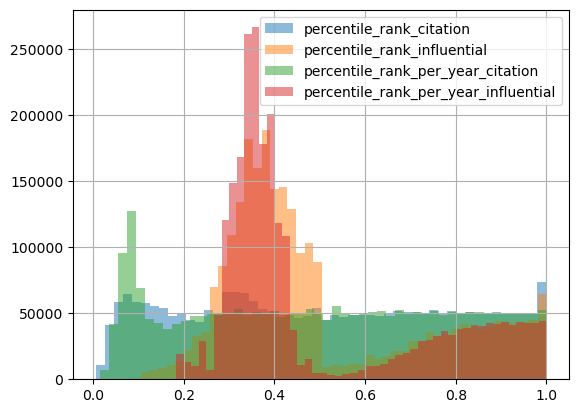

In [18]:
df['percentile_rank_citation'].hist(bins=50, alpha=0.5)
df['percentile_rank_influential'].hist(bins=50, alpha=0.5)
df['percentile_rank_per_year_citation'].hist(bins=50, alpha=0.5)
df['percentile_rank_per_year_influential'].hist(bins=50, alpha=0.5)
plt.legend(['percentile_rank_citation', 'percentile_rank_influential', 'percentile_rank_per_year_citation', 'percentile_rank_per_year_influential'])
plt.show()

### **Datebase to Store the Metrics**

In [22]:
#create a new duckdb database to store the normalized data
con_normalized = duckdb.connect(database='S2_papers_normalized.db')
columns_to_store = ['corpusid',  'citation_count',
       'influential_citation_count', 'citation_count_per_year', 'influential_count_per_year',
       'publication_year', 'percentile_rank_per_year_citation',
       'percentile_rank_per_year_influential', 'percentile_rank_citation',
       'percentile_rank_influential']
con_normalized.execute(f"CREATE TABLE papers_normalized AS SELECT {', '.join(columns_to_store)} FROM df")
con_normalized.close()